In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from os import listdir
from os.path import join
import deepcoloring as dc
%matplotlib inline
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In order to run this example you need to download dataset https://www.plant-phenotyping.org/datasets-download

In [2]:
#Path to the folder
basepath = "/media/hpc-4_Raid/vkulikov/CVPPP2017_LSC_training/training/A1/"
rgb = sorted([join(basepath,f) for f in listdir(basepath) if f.endswith('_rgb.png')])
labels = sorted([join(basepath,f) for f in listdir(basepath) if f.endswith('_label.png')])
#Check the names are paired correctly
assert np.array([img[:-7]==lbl[:-9] for img,lbl in zip(rgb,labels)]).all()==True


indexes = np.random.permutation(len(rgb))
perm_rgb = np.array(rgb)[indexes].tolist()
perm_labels = np.array(labels)[indexes].tolist()


train_data = dc.Reader(perm_rgb[:-10],perm_labels[:-10],2)
valid_data = dc.Reader(perm_rgb[-10:],perm_labels[-10:],2)

In [4]:
transforms = [dc.rgba2rgb(),
              dc.clip_patch((192,192)),
        dc.flip_horizontally(),
        dc.flip_vertically(),
        dc.rotate90(),
        dc.random_transform(0.1,90,0),
        dc.blur(),
        dc.random_gamma(.8),
        dc.normalize(0.5,0.5)]

generator = train_data.create_batch_generator(40,transforms=transforms)
mask_builder = dc.build_halo_mask()

(1.0426623, -1.0, (40, 192, 192, 3))
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


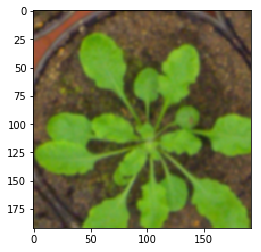

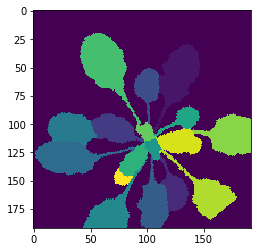

In [6]:
x,y = generator()
r = x.transpose(0,2,3,1)
print(r.max(),r.min(),r.shape)
plt.imshow((r[0]+1.)/2.)
plt.figure()
plt.imshow(y[0].astype(np.int16))
print(np.unique(y))

In [10]:
net = dc.EUnet(3,6,2,2,2,padding=1,init_xavier=True,use_bn=True,use_dropout=True).to(device)
model,errors = dc.train(generator=generator,model=net,mask_builder=mask_builder,niter=7000)

[=================== ] 95%

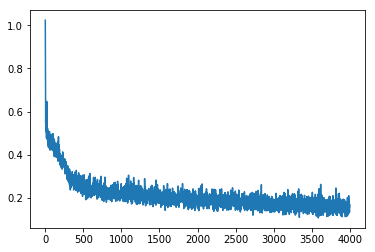

In [11]:
plt.plot(errors)